# Import stuff

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import pandas as pd
import scipy as sp
from scipy import stats, ndimage
from scipy.stats import pearsonr 
from itertools import chain, zip_longest
from copy import deepcopy
import glmtools as glm

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

import mne
from mne.stats import permutation_t_test
mne.set_log_level('warning') 

#%matplotlib qt
%matplotlib inline

input_dir = 'TaskpartnerEpochsMastoids'


In [19]:
def load_subj_eeg(path, file, downsample=None):
    fp = os.path.join(path, '%s-epo.fif' % file)
    print('>>> Loading %s' % fp)
    epochs = mne.read_epochs(fp, preload=True)
    if downsample is not None:
        epochs = epochs.resample(downsample)
    return epochs

def load_all_eeg(path, files, downsample=None):
    subject_epochs = [load_subj_eeg(path, file, downsample=downsample) for file in files]
    epochs = mne.epochs.concatenate_epochs(subject_epochs)
    return epochs

In [20]:
def runclustertest_epochs(data, contrast_name, channels, tmin = None, tmax = None, gauss_smoothing = None, out_type = 'indices', n_permutations = 'Default', n_jobs = 1):
    '''
    func to run cluster permutation tests on voltage data (epochs)
    data = data object. dictionary where each key is a contrast name, and inside it is a list (of length nsubs) of Evoked objects
    contrast_name = name of the contrast you want to run the test on
    channels = list. list of channels you want to average over. if one channel only, obviously no averaging across channels. still needs to be list
    tmin, tmax = if you want to restrict permutation tests to a time window, do it here
    gauss_smoothing = width (sigma) of a gaussian smoothing that is performed on the single subject data prior to running the test. if None (default) - no smoothing.
                      NOTE: the time width of this smoothing depends on your sampling frequency so make sure to use this properly
    out_type = specify output type. default to indices, can set to mask if you really want
    '''
    import scipy as sp
    from scipy import ndimage
    from copy import deepcopy
    
    dat       = deepcopy(data[contrast_name])
    nsubs     = len(dat)
    times    = deepcopy(dat[0]).crop(tmin=tmin, tmax=tmax).times
    cludat    = np.empty(shape = (nsubs, 1, times.size)) #specify 1 because we're going to average across channels anyway
    
    for i in range(nsubs):
        tmp = deepcopy(dat[i])
        tmp.crop(tmin=tmin, tmax=tmax).pick_channels(channels) #select time window and channels we want
        if gauss_smoothing != None:
            cludat[i,:,:] = sp.ndimage.gaussian_filter1d(np.nanmean(tmp.data, axis=0), sigma = gauss_smoothing)
        else:
            cludat[i,:,:] = np.nanmean(tmp.data, axis=0) #average across channels
    if n_permutations != 'Default':
        t, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_1samp_test(cludat, out_type=out_type, n_permutations = n_permutations, n_jobs = n_jobs)
    else:
        t, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_1samp_test(cludat, out_type=out_type, n_jobs = n_jobs)
    return t, clusters, cluster_pv, H0

In [21]:
def nanzscore(vector, zero_out_nans = True):
            '''
            zscore a vector ignoring nans
            optionally can set nans to 0 afterwards. useful for regressors
            '''
            vector = np.divide(np.subtract(vector, np.nanmean(vector)), np.nanstd(vector))
            if zero_out_nans:
                vector = np.where(np.isnan(vector), 0, vector)
            
            return vector

In [22]:
participant_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21] # 14 was excluded due to noise

sessions = [1, 2]

partners = ['"overconfident"', '"underconfident"']


# Adding partner / condition

## FRN = 1 + agreement + condition + partner

In [60]:
%matplotlib inline

for sub in participant_numbers:
    participant_files = []
    for session in sessions:
        participant_files.append('%i_%i' % (sub, session))
    epochs = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    

    #set up glm
    glmdata = glm.data.TrialGLMData(data = epochs.get_data(), time_dim = 2, sample_rate = 250)
    nobs = glmdata.num_observations
    trials = np.ones(nobs)
    
    # regressors
    confidence = epochs.metadata['participant_confidence'].to_numpy() 
    condition = epochs.metadata['condition'].to_numpy()
    partner = epochs.metadata['partner'].to_numpy()
    agreement = epochs.metadata['agreement'].to_numpy()

    intercept = np.where(condition == 'ns', 1, 1)
    condition = np.where(condition == 'ns', 0, 1)
    partner = np.where(partner == 'underconfident', 0, 1)
    agreement = np.where(agreement == 1, 1, 0) 
    
    
    #add regressors to the model
    regressors = list()
    regressors.append(glm.regressors.CategoricalRegressor(category_list = intercept, codes = 1, name = 'intercept'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = condition, codes = 1, name = 'condition'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = partner, codes = 1, name = 'partner'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = agreement, codes = 1, name = 'agreement'))

    
    #set up contrasts
    contrasts = list()
    contrasts.append(glm.design.Contrast([ 1, 0, 0, 0], 'intercept'))
    contrasts.append(glm.design.Contrast([ 0, 1, 0, 0], 'condition'))
    contrasts.append(glm.design.Contrast([ 0, 0, 1, 0], 'partner'))
    contrasts.append(glm.design.Contrast([ 0, 0, 0, 1], 'agreement'))

    
    glmdes = glm.design.GLMDesign.initialise(regressors, contrasts)

    
    #run GLM
    tmin = epochs.tmin
    info = epochs.info
    model = glm.fit.OLSModel(glmdes, glmdata)


    #save betas and t-stats
    for iname in range(len(glmdes.contrast_names)):
        name = glmdes.contrast_names[iname].replace(' ','') #remove whitespace in the contrast name
        nave = len(epochs)
        

        tl_betas = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.copes[iname,:,:]))
        # make the path relative later!
        tl_betas.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)    


        
        tl_tstats = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.get_tstats()[iname,:,:]))
        # make the path relative later!
        tl_tstats.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/TstatsEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)

        
   

>>> Loading TaskpartnerEpochsMastoids/1_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/1_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_2-epo.fi

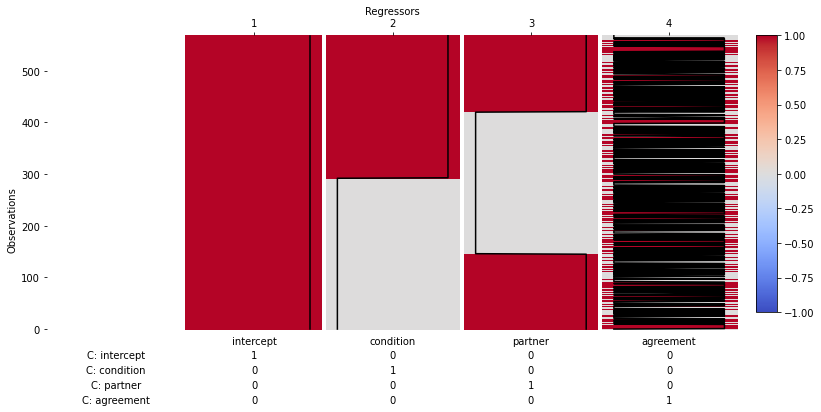

In [61]:
glmdes.plot_summary()
print()  



----------------------- Contrast intercept -----------------------




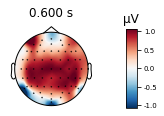

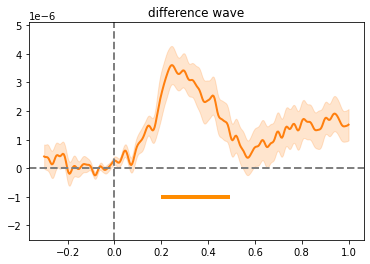



----------------------- Contrast condition -----------------------




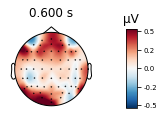

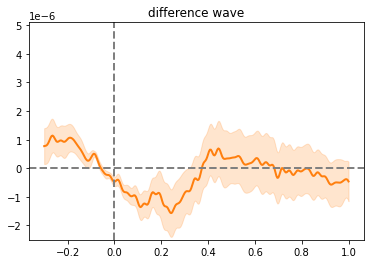



----------------------- Contrast partner -----------------------




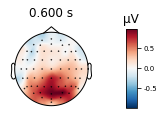

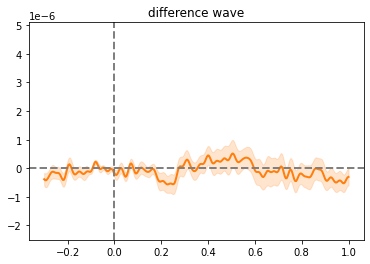



----------------------- Contrast agreement -----------------------




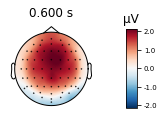

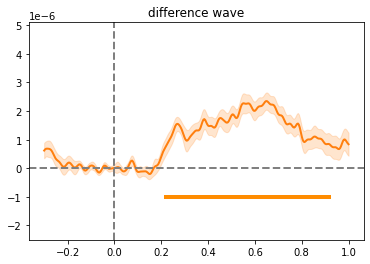

In [65]:
# Define the list of contrasts and region of interest
cs = ['intercept', 'condition', 'partner', 'agreement']
roi = ["FCz"]

sub_betacoefs = dict()

# Loop through each contrast
for c in cs:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Contrast %s -----------------------\n" % c)
    print('\033[0m')

    # Initialize an empty list for storing betas of each subject
    sub_betas = []

    # Loop through each subject and read their beta values
    for subject in participant_numbers:   
        sub_beta = mne.read_evokeds(fname='/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (c, subject))[0]
        sub_betas.append(sub_beta)

    # Compute the grand average of beta values
    gave = mne.grand_average(sub_betas)

    # Plot the grand average topomap for the current contrast
    fig = gave.plot_topomap(times=[0.6], average=0.2, contours=0, extrapolate='head')
    fig.savefig('Figures/contrast_topoplot_%s.pdf' % c, bbox_inches='tight')

    # Store betas in a dictionary
    sub_betacoefs[c] = deepcopy(sub_betas)

    # Set the time window for clustering
    tmin, tmax = 0.2, 1

    # Initialize dictionaries for storing cluster test results
    t_cope, clu_cope, clupv_cope, h0_cope, masks_cope = dict(), dict(), dict(), dict(), dict()

    # Create nested dictionaries for the current contrast and each channel in the ROI
    for contrast in [c]:
        for dictobj in [t_cope, clu_cope, clupv_cope, h0_cope, masks_cope]:
            dictobj[contrast] = dict()
            for channel in roi:
                dictobj[contrast][channel] = []

    # Get the time values for the clustering
    clutimes = deepcopy(sub_betacoefs[c][0]).crop(tmin=tmin, tmax=tmax).times

    # Run the cluster test for the current contrast and each channel in the ROI
    for contrast in [c]:
        for channel in roi:
            t_cope[contrast][channel], clu_cope[contrast][channel], clupv_cope[contrast][channel], h0_cope[contrast][channel] = runclustertest_epochs(
                        data=sub_betacoefs,
                        contrast_name=contrast,
                        channels=[channel],
                        tmin=tmin, tmax=tmax,
                        gauss_smoothing=None,
                        out_type='indices', n_permutations=5000)
            masks_cope[contrast][channel] = np.asarray(clu_cope[contrast][channel])[clupv_cope[contrast][channel] < 0.05]

    # Plot the time course for the current contrast and each channel in the ROI
    for channel in roi:
        tmp = mne.grand_average(sub_betacoefs[c])
        tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])]
        nsubs = len(sub_betacoefs[c])
        ntimes = sub_betacoefs[c][0].times.size
        times = sub_betacoefs[c][0].times
        tmpempty = np.empty(shape=(nsubs, ntimes))
        
        # Calculate the mean and standard error of the mean for each time point
        for i in range(nsubs):
            tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[c][i]).pick_channels([channel]).get_data())
        tmpmean = np.nanmean(tmpempty, 0)
        tmpsem  = sp.stats.sem(tmpempty, 0)

        # Create a new figure for the time course plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(times, tmpmean, lw=2, color='C1')
        ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color='C1')
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')

        # Plot significant clusters on the time course plot
        for contrast in [c]:
            y_sig = -1e-6
            if contrast == "confidence":
                y_sig = -1e-7
            for imask in range(len(masks_cope[contrast][channel])):
                ax.hlines(y=y_sig,
                          xmin=np.min(clutimes[masks_cope[contrast][channel][imask][1]]),
                          xmax=np.max(clutimes[masks_cope[contrast][channel][imask][1]]),
                          lw=4, color='darkorange')

        # Set the title and save the figure
        # ax.set_title(f'Electrode {channel} - difference wave')
        ax.set_title('difference wave')
        ax.set_ylim([-2.5e-6, 5.1e-6])
        fig.savefig('Figures/contrast_timecourse_%s.pdf' % c, bbox_inches='tight')

        # Display the figure and close it
        display(fig)
        plt.close()




----------------------- Model condition -----------------------




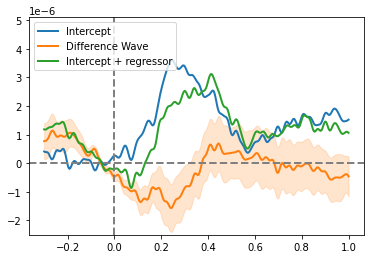



----------------------- Model partner -----------------------




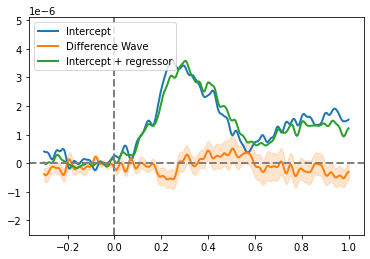



----------------------- Model agreement -----------------------




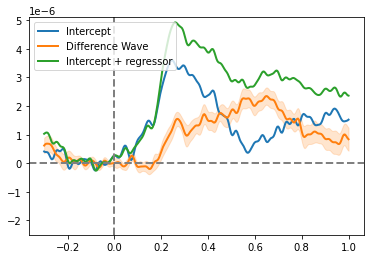

In [64]:
# Loop through each contrast
for c in cs[1:]:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Model %s -----------------------\n" % c)
    print('\033[0m')

    # Loop through each channel in the ROI
    for channel in roi:
        # Create a new figure for the time course plot
        fig, ax = plt.subplots()

        for idx, (contrast, label) in enumerate(zip([cs[0], c], ['Intercept', f'Difference Wave'])):

            # Compute the grand average of beta values
            tmp = mne.grand_average(sub_betacoefs[contrast])
            tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[contrast])]
            nsubs = len(sub_betacoefs[contrast])
            ntimes = sub_betacoefs[contrast][0].times.size
            times = sub_betacoefs[contrast][0].times
            tmpempty = np.empty(shape=(nsubs, ntimes))

            # Calculate the mean and standard error of the mean for each time point
            for i in range(nsubs):
                tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[contrast][i]).pick_channels([channel]).get_data())
            tmpmean = np.nanmean(tmpempty, 0)
            tmpsem  = sp.stats.sem(tmpempty, 0)

            # Plot the time course
            color = f'C{idx}'
            if c != 'confidence' or idx != 0:  # Remove the intercept line from the first (confidence) plot
                ax.plot(times, tmpmean, lw=2, color=color, label=label)
                if idx == 1:  # Only plot standard error for the orange line (Difference Wave)
                    ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color=color)

        intercept_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[cs[0]])])
        contrast_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])])

        if c == 'confidence':
            # Plot the effect of confidence at different levels
            for level, label, color in zip([-1, +1], ['-1 SD','+1 SD'], ['C0', 'C2']):
                combined_data = intercept_data + (contrast_data * level)
                combined_mean = np.nanmean(combined_data, axis=0)
                combined_sem = sp.stats.sem(combined_data, axis=0)

                ax.plot(times, combined_mean.squeeze(), lw=2, color=color, label=f'Confidence ({label})')
        else:
            combined_data = intercept_data + contrast_data
            combined_mean = np.nanmean(combined_data, axis=0)
            combined_sem = sp.stats.sem(combined_data, axis=0)

            ax.plot(times, combined_mean.squeeze(), lw=2, color='C2', label=f'Intercept + regressor')

        # Set up the figure
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')
        ax.set_title(f'')
        ax.legend(loc='upper left')
        ax.set_ylim([-2.5e-6, 5.1e-6])

        # Save and display the figure
        fig.savefig(f'Figures/model_timecourse_FCz_{c}.pdf', bbox_inches='tight')
        display(fig)
        plt.close()



## FRN = 1 + agreement * partner

In [56]:
%matplotlib inline

for sub in participant_numbers:
    participant_files = []
    for session in sessions:
        participant_files.append('%i_%i' % (sub, session))
    epochs = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    

    #set up glm
    glmdata = glm.data.TrialGLMData(data = epochs.get_data(), time_dim = 2, sample_rate = 250)
    nobs = glmdata.num_observations
    trials = np.ones(nobs)
    
    # regressors
    confidence = epochs.metadata['participant_confidence'].to_numpy() 
    condition = epochs.metadata['condition'].to_numpy()
    partner = epochs.metadata['partner'].to_numpy()
    agreement = epochs.metadata['agreement'].to_numpy()

    intercept = np.where(condition == 'ns', 1, 1)
    condition = np.where(condition == 'ns', 0, 1)
    partner = np.where(partner == 'underconfident', 0, 1)
    agreement = np.where(agreement == 1, 1, 0) 
    agreementXpartner = agreement*partner

    
    
    #add regressors to the model
    regressors = list()
    regressors.append(glm.regressors.CategoricalRegressor(category_list = intercept, codes = 1, name = 'intercept'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = partner, codes = 1, name = 'partner'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = agreement, codes = 1, name = 'agreement'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = agreementXpartner, codes = 1, name = 'agreementXpartner'))

    
    #set up contrasts
    contrasts = list()
    contrasts.append(glm.design.Contrast([ 1, 0, 0, 0], 'intercept'))
    contrasts.append(glm.design.Contrast([ 0, 1, 0, 0], 'partner'))
    contrasts.append(glm.design.Contrast([ 0, 0, 1, 0], 'agreement'))
    contrasts.append(glm.design.Contrast([ 0, 0, 0, 1], 'agreementXpartner'))

    
    glmdes = glm.design.GLMDesign.initialise(regressors, contrasts)

    
    #run GLM
    tmin = epochs.tmin
    info = epochs.info
    model = glm.fit.OLSModel(glmdes, glmdata)


    #save betas and t-stats
    for iname in range(len(glmdes.contrast_names)):
        name = glmdes.contrast_names[iname].replace(' ','') #remove whitespace in the contrast name
        nave = len(epochs)
        

        tl_betas = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.copes[iname,:,:]))
        # make the path relative later!
        tl_betas.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)    


        
        tl_tstats = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.get_tstats()[iname,:,:]))
        # make the path relative later!
        tl_tstats.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/TstatsEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)

        
   

>>> Loading TaskpartnerEpochsMastoids/1_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/1_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_2-epo.fi

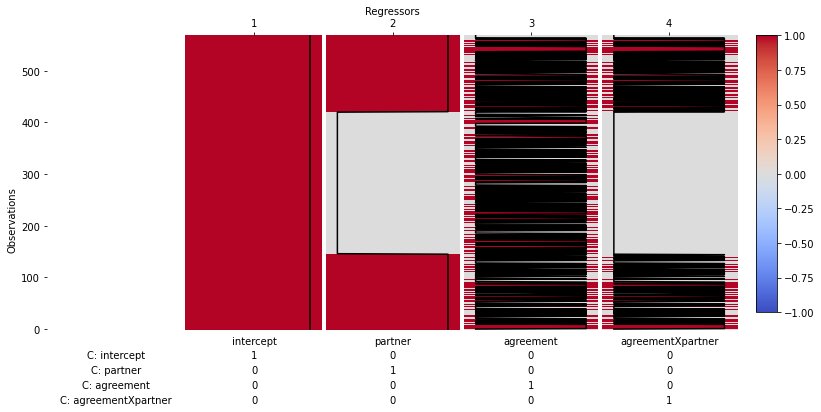

In [57]:
glmdes.plot_summary()
print()  



----------------------- Contrast intercept -----------------------




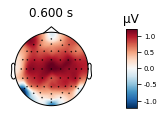

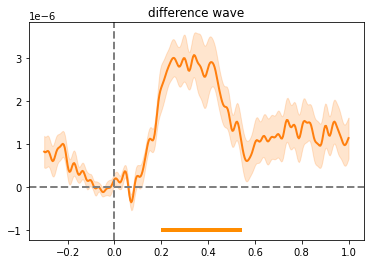



----------------------- Contrast agreementXpartner -----------------------




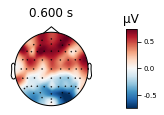

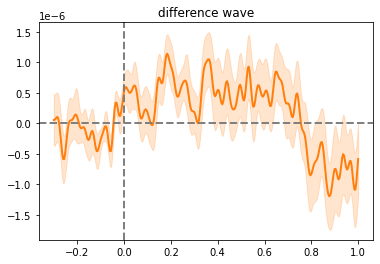



----------------------- Contrast partner -----------------------




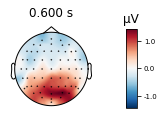

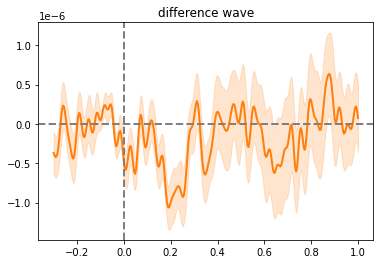



----------------------- Contrast agreement -----------------------




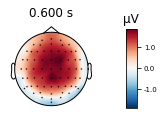

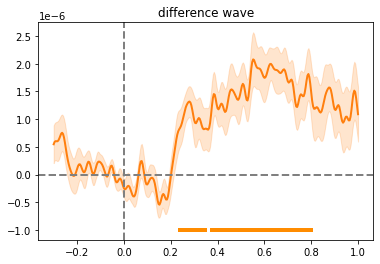

In [58]:
# Define the list of contrasts and region of interest
cs = ['intercept', 'agreementXpartner', 'partner', 'agreement']
roi = ["FCz"]

sub_betacoefs = dict()

# Loop through each contrast
for c in cs:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Contrast %s -----------------------\n" % c)
    print('\033[0m')

    # Initialize an empty list for storing betas of each subject
    sub_betas = []

    # Loop through each subject and read their beta values
    for subject in participant_numbers:   
        sub_beta = mne.read_evokeds(fname='/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (c, subject))[0]
        sub_betas.append(sub_beta)

    # Compute the grand average of beta values
    gave = mne.grand_average(sub_betas)

    # Plot the grand average topomap for the current contrast
    fig = gave.plot_topomap(times=[0.6], average=0.2, contours=0, extrapolate='head')
    fig.savefig('Figures/contrast_topoplot_%s.pdf' % c, bbox_inches='tight')

    # Store betas in a dictionary
    sub_betacoefs[c] = deepcopy(sub_betas)

    # Set the time window for clustering
    tmin, tmax = 0.2, 1

    # Initialize dictionaries for storing cluster test results
    t_cope, clu_cope, clupv_cope, h0_cope, masks_cope = dict(), dict(), dict(), dict(), dict()

    # Create nested dictionaries for the current contrast and each channel in the ROI
    for contrast in [c]:
        for dictobj in [t_cope, clu_cope, clupv_cope, h0_cope, masks_cope]:
            dictobj[contrast] = dict()
            for channel in roi:
                dictobj[contrast][channel] = []

    # Get the time values for the clustering
    clutimes = deepcopy(sub_betacoefs[c][0]).crop(tmin=tmin, tmax=tmax).times

    # Run the cluster test for the current contrast and each channel in the ROI
    for contrast in [c]:
        for channel in roi:
            t_cope[contrast][channel], clu_cope[contrast][channel], clupv_cope[contrast][channel], h0_cope[contrast][channel] = runclustertest_epochs(
                        data=sub_betacoefs,
                        contrast_name=contrast,
                        channels=[channel],
                        tmin=tmin, tmax=tmax,
                        gauss_smoothing=None,
                        out_type='indices', n_permutations=5000)
            masks_cope[contrast][channel] = np.asarray(clu_cope[contrast][channel])[clupv_cope[contrast][channel] < 0.05]

    # Plot the time course for the current contrast and each channel in the ROI
    for channel in roi:
        tmp = mne.grand_average(sub_betacoefs[c])
        tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])]
        nsubs = len(sub_betacoefs[c])
        ntimes = sub_betacoefs[c][0].times.size
        times = sub_betacoefs[c][0].times
        tmpempty = np.empty(shape=(nsubs, ntimes))
        
        # Calculate the mean and standard error of the mean for each time point
        for i in range(nsubs):
            tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[c][i]).pick_channels([channel]).get_data())
        tmpmean = np.nanmean(tmpempty, 0)
        tmpsem  = sp.stats.sem(tmpempty, 0)

        # Create a new figure for the time course plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(times, tmpmean, lw=2, color='C1')
        ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color='C1')
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')

        # Plot significant clusters on the time course plot
        for contrast in [c]:
            y_sig = -1e-6
            if contrast == "confidence":
                y_sig = -1e-7
            for imask in range(len(masks_cope[contrast][channel])):
                ax.hlines(y=y_sig,
                          xmin=np.min(clutimes[masks_cope[contrast][channel][imask][1]]),
                          xmax=np.max(clutimes[masks_cope[contrast][channel][imask][1]]),
                          lw=4, color='darkorange')

        # Set the title and save the figure
        # ax.set_title(f'Electrode {channel} - difference wave')
        ax.set_title('difference wave')
        fig.savefig('Figures/contrast_timecourse_%s.pdf' % c, bbox_inches='tight')

        # Display the figure and close it
        display(fig)
        plt.close()




----------------------- Model agreementXpartner -----------------------




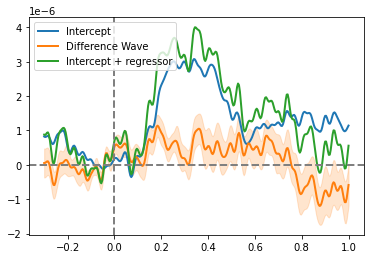



----------------------- Model partner -----------------------




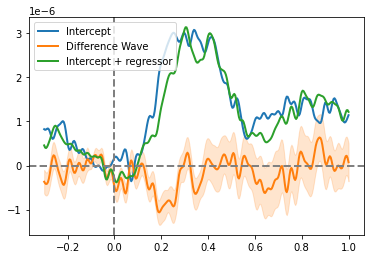



----------------------- Model agreement -----------------------




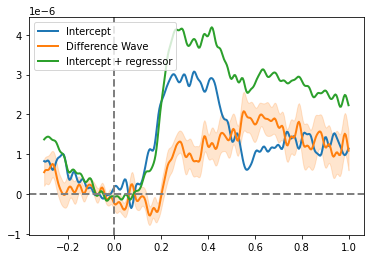

In [59]:
# Loop through each contrast
for c in cs[1:]:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Model %s -----------------------\n" % c)
    print('\033[0m')

    # Loop through each channel in the ROI
    for channel in roi:
        # Create a new figure for the time course plot
        fig, ax = plt.subplots()

        for idx, (contrast, label) in enumerate(zip([cs[0], c], ['Intercept', f'Difference Wave'])):

            # Compute the grand average of beta values
            tmp = mne.grand_average(sub_betacoefs[contrast])
            tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[contrast])]
            nsubs = len(sub_betacoefs[contrast])
            ntimes = sub_betacoefs[contrast][0].times.size
            times = sub_betacoefs[contrast][0].times
            tmpempty = np.empty(shape=(nsubs, ntimes))

            # Calculate the mean and standard error of the mean for each time point
            for i in range(nsubs):
                tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[contrast][i]).pick_channels([channel]).get_data())
            tmpmean = np.nanmean(tmpempty, 0)
            tmpsem  = sp.stats.sem(tmpempty, 0)

            # Plot the time course
            color = f'C{idx}'
            if c != 'confidence' or idx != 0:  # Remove the intercept line from the first (confidence) plot
                ax.plot(times, tmpmean, lw=2, color=color, label=label)
                if idx == 1:  # Only plot standard error for the orange line (Difference Wave)
                    ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color=color)

        intercept_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[cs[0]])])
        contrast_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])])

        if c == 'confidence':
            # Plot the effect of confidence at different levels
            for level, label, color in zip([-1, +1], ['-1 SD','+1 SD'], ['C0', 'C2']):
                combined_data = intercept_data + (contrast_data * level)
                combined_mean = np.nanmean(combined_data, axis=0)
                combined_sem = sp.stats.sem(combined_data, axis=0)

                ax.plot(times, combined_mean.squeeze(), lw=2, color=color, label=f'Confidence ({label})')
        else:
            combined_data = intercept_data + contrast_data
            combined_mean = np.nanmean(combined_data, axis=0)
            combined_sem = sp.stats.sem(combined_data, axis=0)

            ax.plot(times, combined_mean.squeeze(), lw=2, color='C2', label=f'Intercept + regressor')

        # Set up the figure
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')
        ax.set_title(f'')
        ax.legend(loc='upper left')

        # Save and display the figure
        #fig.savefig(f'Figures/model_timecourse_{c}.pdf', bbox_inches='tight')
        display(fig)
        plt.close()



## FRN = 1 + agreement * partner-confidence

In [50]:
%matplotlib inline

for sub in participant_numbers:
    participant_files = []
    for session in sessions:
        participant_files.append('%i_%i' % (sub, session))
    epochs = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    

    #set up glm
    glmdata = glm.data.TrialGLMData(data = epochs.get_data(), time_dim = 2, sample_rate = 250)
    nobs = glmdata.num_observations
    trials = np.ones(nobs)
    
    # regressors
    confidence = epochs.metadata['participant_confidence'].to_numpy() 
    condition = epochs.metadata['condition'].to_numpy()
    partner = epochs.metadata['partner'].to_numpy()
    agreement = epochs.metadata['agreement'].to_numpy()
    partnerC = epochs.metadata['partner_confidence'].to_numpy()

    intercept = np.where(condition == 'ns', 1, 1)
    agreement = np.where(agreement == 1, 1, -1) 
    agreementXpartnerC = agreement*partnerC

    
    
    #add regressors to the model
    regressors = list()
    regressors.append(glm.regressors.CategoricalRegressor(category_list = intercept, codes = 1, name = 'intercept'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = agreement, codes = 1, name = 'agreement'))
    #regressors.append(glm.regressors.ParametricRegressor(name = 'partnerC', values = partnerC, preproc = None, num_observations = nobs))
    regressors.append(glm.regressors.ParametricRegressor(name = 'agreementXpartnerC', values = agreementXpartnerC, preproc = None, num_observations = nobs))

    
    #set up contrasts
    contrasts = list()
    contrasts.append(glm.design.Contrast([ 1, 0, 0], 'intercept'))
    contrasts.append(glm.design.Contrast([ 0, 1, 0], 'agreement'))
    ##contrasts.append(glm.design.Contrast([ 0, 0, 1, 0], 'partnerC'))
    contrasts.append(glm.design.Contrast([ 0, 0, 1], 'agreementXpartnerC'))

    
    glmdes = glm.design.GLMDesign.initialise(regressors, contrasts)

    
    #run GLM
    tmin = epochs.tmin
    info = epochs.info
    model = glm.fit.OLSModel(glmdes, glmdata)


    #save betas and t-stats
    for iname in range(len(glmdes.contrast_names)):
        name = glmdes.contrast_names[iname].replace(' ','') #remove whitespace in the contrast name
        nave = len(epochs)
        

        tl_betas = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.copes[iname,:,:]))
        # make the path relative later!
        tl_betas.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)    


        
        tl_tstats = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.get_tstats()[iname,:,:]))
        # make the path relative later!
        tl_tstats.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/TstatsEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)

        
   

>>> Loading TaskpartnerEpochsMastoids/1_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/1_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_2-epo.fi

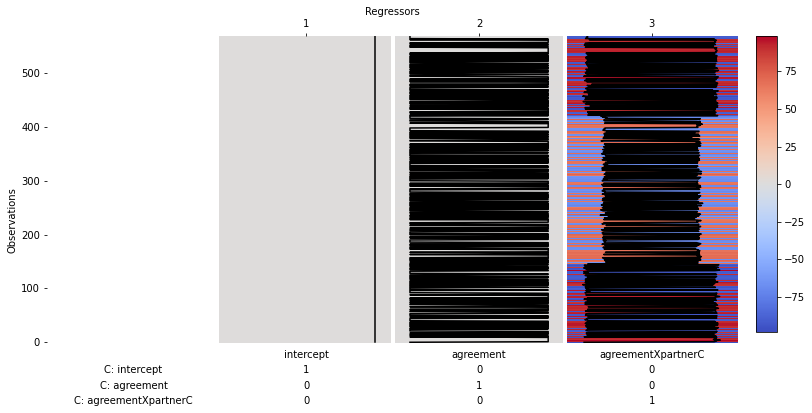

In [51]:
glmdes.plot_summary()
print()  



----------------------- Contrast intercept -----------------------




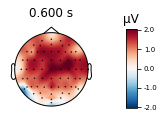

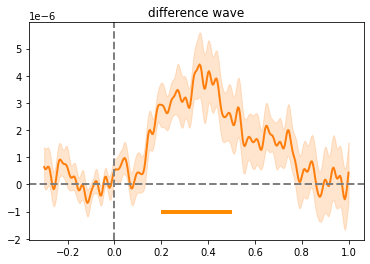



----------------------- Contrast agreement -----------------------




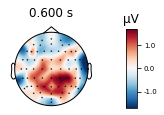

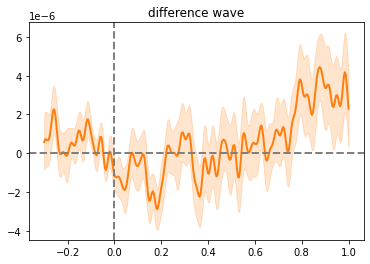



----------------------- Contrast agreementXpartnerC -----------------------




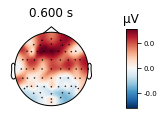

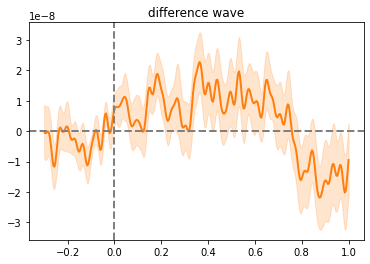

In [54]:
# Define the list of contrasts and region of interest
# cs = ['intercept', 'agreement', 'partnerC', 'agreementXpartnerC']
cs = ['intercept', 'agreement', 'agreementXpartnerC']
roi = ["FCz"]

sub_betacoefs = dict()

# Loop through each contrast
for c in cs:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Contrast %s -----------------------\n" % c)
    print('\033[0m')

    # Initialize an empty list for storing betas of each subject
    sub_betas = []

    # Loop through each subject and read their beta values
    for subject in participant_numbers:   
        sub_beta = mne.read_evokeds(fname='/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (c, subject))[0]
        sub_betas.append(sub_beta)

    # Compute the grand average of beta values
    gave = mne.grand_average(sub_betas)

    # Plot the grand average topomap for the current contrast
    fig = gave.plot_topomap(times=[0.6], average=0.2, contours=0, extrapolate='head')
    fig.savefig('Figures/contrast_topoplot_%s.pdf' % c, bbox_inches='tight')

    # Store betas in a dictionary
    sub_betacoefs[c] = deepcopy(sub_betas)

    # Set the time window for clustering
    tmin, tmax = 0.2, 1

    # Initialize dictionaries for storing cluster test results
    t_cope, clu_cope, clupv_cope, h0_cope, masks_cope = dict(), dict(), dict(), dict(), dict()

    # Create nested dictionaries for the current contrast and each channel in the ROI
    for contrast in [c]:
        for dictobj in [t_cope, clu_cope, clupv_cope, h0_cope, masks_cope]:
            dictobj[contrast] = dict()
            for channel in roi:
                dictobj[contrast][channel] = []

    # Get the time values for the clustering
    clutimes = deepcopy(sub_betacoefs[c][0]).crop(tmin=tmin, tmax=tmax).times

    # Run the cluster test for the current contrast and each channel in the ROI
    for contrast in [c]:
        for channel in roi:
            t_cope[contrast][channel], clu_cope[contrast][channel], clupv_cope[contrast][channel], h0_cope[contrast][channel] = runclustertest_epochs(
                        data=sub_betacoefs,
                        contrast_name=contrast,
                        channels=[channel],
                        tmin=tmin, tmax=tmax,
                        gauss_smoothing=None,
                        out_type='indices', n_permutations=5000)
            masks_cope[contrast][channel] = np.asarray(clu_cope[contrast][channel])[clupv_cope[contrast][channel] < 0.05]

    # Plot the time course for the current contrast and each channel in the ROI
    for channel in roi:
        tmp = mne.grand_average(sub_betacoefs[c])
        tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])]
        nsubs = len(sub_betacoefs[c])
        ntimes = sub_betacoefs[c][0].times.size
        times = sub_betacoefs[c][0].times
        tmpempty = np.empty(shape=(nsubs, ntimes))
        
        # Calculate the mean and standard error of the mean for each time point
        for i in range(nsubs):
            tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[c][i]).pick_channels([channel]).get_data())
        tmpmean = np.nanmean(tmpempty, 0)
        tmpsem  = sp.stats.sem(tmpempty, 0)

        # Create a new figure for the time course plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(times, tmpmean, lw=2, color='C1')
        ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color='C1')
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')

        # Plot significant clusters on the time course plot
        for contrast in [c]:
            y_sig = -1e-6
            if contrast == "confidence":
                y_sig = -1e-7
            for imask in range(len(masks_cope[contrast][channel])):
                ax.hlines(y=y_sig,
                          xmin=np.min(clutimes[masks_cope[contrast][channel][imask][1]]),
                          xmax=np.max(clutimes[masks_cope[contrast][channel][imask][1]]),
                          lw=4, color='darkorange')

        # Set the title and save the figure
        # ax.set_title(f'Electrode {channel} - difference wave')
        ax.set_title('difference wave')
        fig.savefig('Figures/contrast_timecourse_%s.pdf' % c, bbox_inches='tight')

        # Display the figure and close it
        display(fig)
        plt.close()




----------------------- Model agreement -----------------------




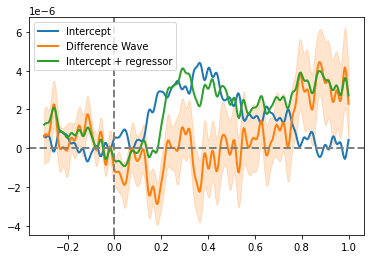



----------------------- Model agreementXpartnerC -----------------------




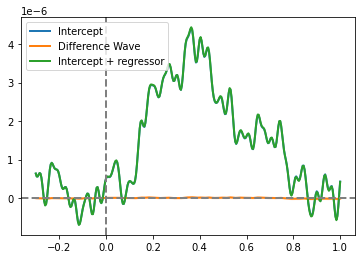

In [55]:
# Loop through each contrast
for c in cs[1:]:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Model %s -----------------------\n" % c)
    print('\033[0m')

    # Loop through each channel in the ROI
    for channel in roi:
        # Create a new figure for the time course plot
        fig, ax = plt.subplots()

        for idx, (contrast, label) in enumerate(zip([cs[0], c], ['Intercept', f'Difference Wave'])):

            # Compute the grand average of beta values
            tmp = mne.grand_average(sub_betacoefs[contrast])
            tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[contrast])]
            nsubs = len(sub_betacoefs[contrast])
            ntimes = sub_betacoefs[contrast][0].times.size
            times = sub_betacoefs[contrast][0].times
            tmpempty = np.empty(shape=(nsubs, ntimes))

            # Calculate the mean and standard error of the mean for each time point
            for i in range(nsubs):
                tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[contrast][i]).pick_channels([channel]).get_data())
            tmpmean = np.nanmean(tmpempty, 0)
            tmpsem  = sp.stats.sem(tmpempty, 0)

            # Plot the time course
            color = f'C{idx}'
            if c != 'confidence' or idx != 0:  # Remove the intercept line from the first (confidence) plot
                ax.plot(times, tmpmean, lw=2, color=color, label=label)
                if idx == 1:  # Only plot standard error for the orange line (Difference Wave)
                    ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color=color)

        intercept_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[cs[0]])])
        contrast_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])])

        if c == 'confidence':
            # Plot the effect of confidence at different levels
            for level, label, color in zip([-1, +1], ['-1 SD','+1 SD'], ['C0', 'C2']):
                combined_data = intercept_data + (contrast_data * level)
                combined_mean = np.nanmean(combined_data, axis=0)
                combined_sem = sp.stats.sem(combined_data, axis=0)

                ax.plot(times, combined_mean.squeeze(), lw=2, color=color, label=f'Confidence ({label})')
        else:
            combined_data = intercept_data + contrast_data
            combined_mean = np.nanmean(combined_data, axis=0)
            combined_sem = sp.stats.sem(combined_data, axis=0)

            ax.plot(times, combined_mean.squeeze(), lw=2, color='C2', label=f'Intercept + regressor')

        # Set up the figure
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')
        ax.set_title(f'')
        ax.legend(loc='upper left')

        # Save and display the figure
        #fig.savefig(f'Figures/model_timecourse_{c}.pdf', bbox_inches='tight')
        display(fig)
        plt.close()



## STRATEGIC FRN = 1 + agreement * partner

In [83]:
%matplotlib inline

for sub in participant_numbers:
    participant_files = []
    for session in sessions:
        participant_files.append('%i_%i' % (sub, session))
    epochs = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    epochs_t = epochs['condition == "s"']
    

    #set up glm
    glmdata = glm.data.TrialGLMData(data = epochs_t.get_data(), time_dim = 2, sample_rate = 250)
    nobs = glmdata.num_observations
    trials = np.ones(nobs)
    
    # regressors
    confidence = epochs_t.metadata['participant_confidence'].to_numpy() 
    condition = epochs_t.metadata['condition'].to_numpy()
    partner = epochs_t.metadata['partner'].to_numpy()
    agreement = epochs_t.metadata['agreement'].to_numpy()

    intercept = np.where(condition == 's', 1, 1)
    condition = np.where(condition == 'ns', 0, 1)
    partner = np.where(partner == 'underconfident', 0, 1)
    agreement = np.where(agreement == 1, 1, 0) 
    agreementXpartner = agreement*partner

    
    
    #add regressors to the model
    regressors = list()
    regressors.append(glm.regressors.CategoricalRegressor(category_list = intercept, codes = 1, name = 'intercept'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = partner, codes = 1, name = 'partner'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = agreement, codes = 1, name = 'agreement'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = agreementXpartner, codes = 1, name = 'agreementXpartner'))

    
    #set up contrasts
    contrasts = list()
    contrasts.append(glm.design.Contrast([ 1, 0, 0, 0], 'intercept'))
    contrasts.append(glm.design.Contrast([ 0, 1, 0, 0], 'partner'))
    contrasts.append(glm.design.Contrast([ 0, 0, 1, 0], 'agreement'))
    contrasts.append(glm.design.Contrast([ 0, 0, 0, 1], 'agreementXpartner'))

    
    glmdes = glm.design.GLMDesign.initialise(regressors, contrasts)

    
    #run GLM
    tmin = epochs_t.tmin
    info = epochs_t.info
    model = glm.fit.OLSModel(glmdes, glmdata)


    #save betas and t-stats
    for iname in range(len(glmdes.contrast_names)):
        name = glmdes.contrast_names[iname].replace(' ','') #remove whitespace in the contrast name
        nave = len(epochs_t)
        

        tl_betas = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.copes[iname,:,:]))
        # make the path relative later!
        tl_betas.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)    


        
        tl_tstats = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.get_tstats()[iname,:,:]))
        # make the path relative later!
        tl_tstats.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/TstatsEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)

        
   

>>> Loading TaskpartnerEpochsMastoids/1_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/1_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_2-epo.fi

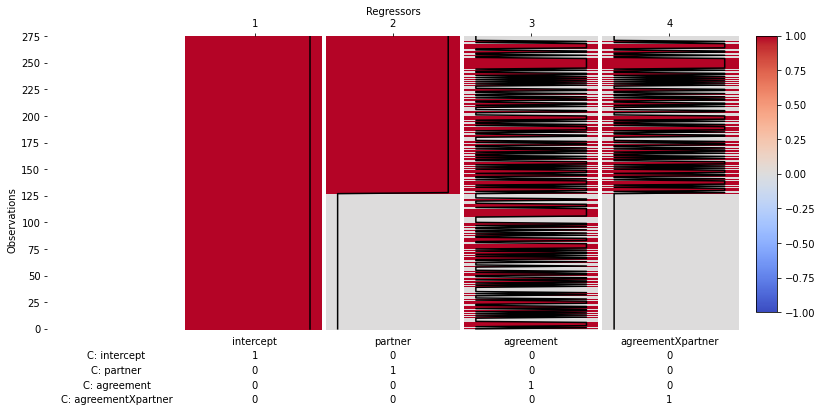

In [84]:
glmdes.plot_summary()
print()  



----------------------- Contrast intercept -----------------------




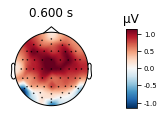

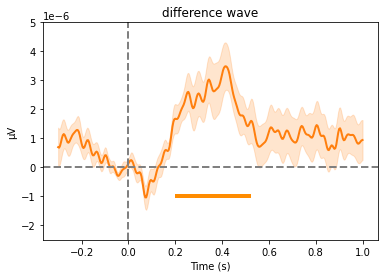



----------------------- Contrast agreementXpartner -----------------------




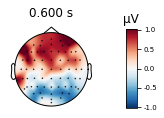

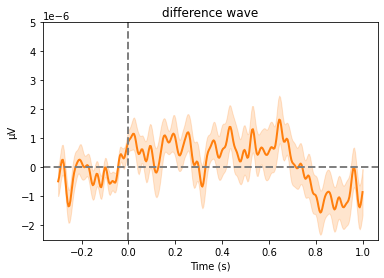



----------------------- Contrast partner -----------------------




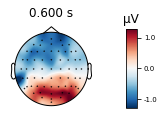

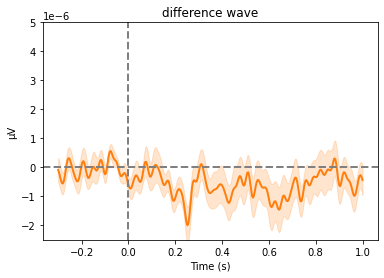



----------------------- Contrast agreement -----------------------




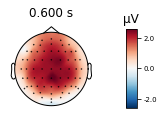

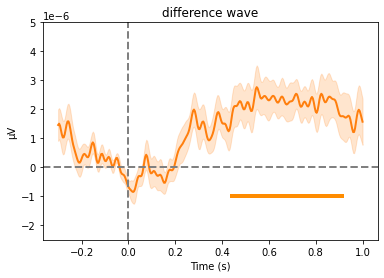

In [91]:
# Define the list of contrasts and region of interest
cs = ['intercept', 'agreementXpartner', 'partner', 'agreement']
#roi = ["Pz", "CPz", "POz", "P1", "P2"]
roi = ["FCz"]

sub_betacoefs = dict()

# Loop through each contrast
for c in cs:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Contrast %s -----------------------\n" % c)
    print('\033[0m')

    # Initialize an empty list for storing betas of each subject
    sub_betas = []

    # Loop through each subject and read their beta values
    for subject in participant_numbers:   
        sub_beta = mne.read_evokeds(fname='/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (c, subject))[0]
        sub_betas.append(sub_beta)

    # Compute the grand average of beta values
    gave = mne.grand_average(sub_betas)

    # Plot the grand average topomap for the current contrast
    fig = gave.plot_topomap(times=[0.6], average=0.2, contours=0, extrapolate='head')
    fig.savefig('Figures/contrast_topoplot_normativ_FCz_%s.pdf' % c, bbox_inches='tight')

    # Store betas in a dictionary
    sub_betacoefs[c] = deepcopy(sub_betas)

    # Set the time window for clustering
    tmin, tmax = 0.2, 1

    # Initialize dictionaries for storing cluster test results
    t_cope, clu_cope, clupv_cope, h0_cope, masks_cope = dict(), dict(), dict(), dict(), dict()

    # Create nested dictionaries for the current contrast and each channel in the ROI
    for contrast in [c]:
        for dictobj in [t_cope, clu_cope, clupv_cope, h0_cope, masks_cope]:
            dictobj[contrast] = dict()
            for channel in roi:
                dictobj[contrast][channel] = []

    # Get the time values for the clustering
    clutimes = deepcopy(sub_betacoefs[c][0]).crop(tmin=tmin, tmax=tmax).times

    # Run the cluster test for the current contrast and each channel in the ROI
    for contrast in [c]:
        for channel in roi:
            t_cope[contrast][channel], clu_cope[contrast][channel], clupv_cope[contrast][channel], h0_cope[contrast][channel] = runclustertest_epochs(
                        data=sub_betacoefs,
                        contrast_name=contrast,
                        channels=[channel],
                        tmin=tmin, tmax=tmax,
                        gauss_smoothing=None,
                        out_type='indices', n_permutations=5000)
            masks_cope[contrast][channel] = np.asarray(clu_cope[contrast][channel])[clupv_cope[contrast][channel] < 0.05]

    # Plot the time course for the current contrast and each channel in the ROI
    for channel in roi:
        tmp = mne.grand_average(sub_betacoefs[c])
        tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])]
        nsubs = len(sub_betacoefs[c])
        ntimes = sub_betacoefs[c][0].times.size
        times = sub_betacoefs[c][0].times
        tmpempty = np.empty(shape=(nsubs, ntimes))
        
        # Calculate the mean and standard error of the mean for each time point
        for i in range(nsubs):
            tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[c][i]).pick_channels([channel]).get_data())
        tmpmean = np.nanmean(tmpempty, 0)
        tmpsem  = sp.stats.sem(tmpempty, 0)

        # Create a new figure for the time course plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(times, tmpmean, lw=2, color='C1')
        ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color='C1')
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')

        # Plot significant clusters on the time course plot
        for contrast in [c]:
            y_sig = -1e-6
            if contrast == "confidence":
                y_sig = -1e-6
            for imask in range(len(masks_cope[contrast][channel])):
                ax.hlines(y=y_sig,
                          xmin=np.min(clutimes[masks_cope[contrast][channel][imask][1]]),
                          xmax=np.max(clutimes[masks_cope[contrast][channel][imask][1]]),
                          lw=4, color='darkorange')

        # Set the title and save the figure
        # ax.set_title(f'Electrode {channel} - difference wave')
        ax.set_ylim([-2.5e-6, 5e-6])
        
        # Set the X-axis and Y-axis labels
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('µV')
        ax.set_title('difference wave')
        fig.savefig('Figures/contrast_timecourse_normative_FCz_%s.pdf' % c, bbox_inches='tight')

        # Display the figure and close it
        display(fig)
        plt.close()








----------------------- Model agreementXpartner -----------------------




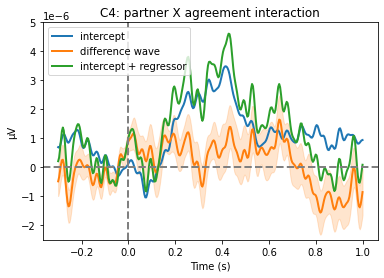



----------------------- Model partner -----------------------




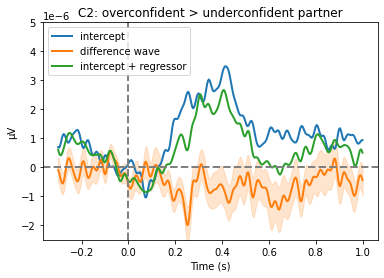



----------------------- Model agreement -----------------------




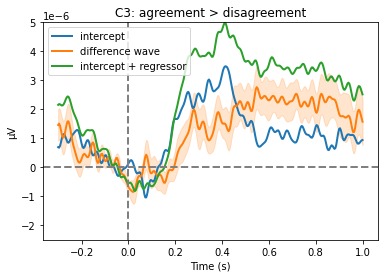

In [87]:
plot_titles = {
    "agreementXpartner": "C4: partner X agreement interaction",
    "partner": "C2: overconfident > underconfident partner",
    "agreement": "C3: agreement > disagreement"
}

# Loop through each contrast
for c in cs[1:]:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Model %s -----------------------\n" % c)
    print('\033[0m')

    # Loop through each channel in the ROI
    for channel in roi:
        # Create a new figure for the time course plot
        fig, ax = plt.subplots()

        for idx, (contrast, label) in enumerate(zip([cs[0], c], ['intercept', f'difference wave'])):

            # Compute the grand average of beta values
            tmp = mne.grand_average(sub_betacoefs[contrast])
            tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[contrast])]
            nsubs = len(sub_betacoefs[contrast])
            ntimes = sub_betacoefs[contrast][0].times.size
            times = sub_betacoefs[contrast][0].times
            tmpempty = np.empty(shape=(nsubs, ntimes))

            # Calculate the mean and standard error of the mean for each time point
            for i in range(nsubs):
                tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[contrast][i]).pick_channels([channel]).get_data())
            tmpmean = np.nanmean(tmpempty, 0)
            tmpsem  = sp.stats.sem(tmpempty, 0)

            # Plot the time course
            color = f'C{idx}'
            if c != 'confidence' or idx != 0:  # Remove the intercept line from the first (confidence) plot
                ax.plot(times, tmpmean, lw=2, color=color, label=label)
                if idx == 1:  # Only plot standard error for the orange line (Difference Wave)
                    ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color=color)

        intercept_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[cs[0]])])
        contrast_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])])

        if c == 'confidence':
            # Plot the effect of confidence at different levels
            for level, label, color in zip([0, +1], ['intercept','+1 SD'], ['C0', 'C2']):
                combined_data = intercept_data + (contrast_data * level)
                combined_mean = np.nanmean(combined_data, axis=0)
                combined_sem = sp.stats.sem(combined_data, axis=0)

                ax.plot(times, combined_mean.squeeze(), lw=2, color=color, label=f'confidence ({label})')
        else:
            combined_data = intercept_data + contrast_data
            combined_mean = np.nanmean(combined_data, axis=0)     
            combined_sem = sp.stats.sem(combined_data, axis=0)

            ax.plot(times, combined_mean.squeeze(), lw=2, color='C2', label=f'intercept + regressor')

        # Set up the figure
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')
        ax.set_title(plot_titles[c])
        ax.legend(loc='upper left')
        ax.set_ylim([-2.5e-6, 5e-6])
        
        # Set the X-axis and Y-axis labels
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('µV')

        # Save and display the figure
        fig.savefig(f'Figures/model_timecourse_normative_FCz_{c}.pdf', bbox_inches='tight')
        display(fig)
        plt.close()



## NON-STRATEGIC FRN = 1 + agreement * partner

In [92]:
%matplotlib inline

for sub in participant_numbers:
    participant_files = []
    for session in sessions:
        participant_files.append('%i_%i' % (sub, session))
    epochs = load_all_eeg(path='%s/' % input_dir, files=participant_files)
    epochs_t = epochs['condition == "ns"']
    

    #set up glm
    glmdata = glm.data.TrialGLMData(data = epochs_t.get_data(), time_dim = 2, sample_rate = 250)
    nobs = glmdata.num_observations
    trials = np.ones(nobs)
    
    # regressors
    confidence = epochs_t.metadata['participant_confidence'].to_numpy() 
    condition = epochs_t.metadata['condition'].to_numpy()
    partner = epochs_t.metadata['partner'].to_numpy()
    agreement = epochs_t.metadata['agreement'].to_numpy()

    intercept = np.where(condition == 'ns', 1, 1)
    condition = np.where(condition == 'ns', 0, 1)
    partner = np.where(partner == 'underconfident', 0, 1)
    agreement = np.where(agreement == 1, 1, 0) 
    agreementXpartner = agreement*partner

    
    
    #add regressors to the model
    regressors = list()
    regressors.append(glm.regressors.CategoricalRegressor(category_list = intercept, codes = 1, name = 'intercept'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = partner, codes = 1, name = 'partner'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = agreement, codes = 1, name = 'agreement'))
    regressors.append(glm.regressors.CategoricalRegressor(category_list = agreementXpartner, codes = 1, name = 'agreementXpartner'))

    
    #set up contrasts
    contrasts = list()
    contrasts.append(glm.design.Contrast([ 1, 0, 0, 0], 'intercept'))
    contrasts.append(glm.design.Contrast([ 0, 1, 0, 0], 'partner'))
    contrasts.append(glm.design.Contrast([ 0, 0, 1, 0], 'agreement'))
    contrasts.append(glm.design.Contrast([ 0, 0, 0, 1], 'agreementXpartner'))

    
    glmdes = glm.design.GLMDesign.initialise(regressors, contrasts)

    
    #run GLM
    tmin = epochs_t.tmin
    info = epochs_t.info
    model = glm.fit.OLSModel(glmdes, glmdata)


    #save betas and t-stats
    for iname in range(len(glmdes.contrast_names)):
        name = glmdes.contrast_names[iname].replace(' ','') #remove whitespace in the contrast name
        nave = len(epochs_t)
        

        tl_betas = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.copes[iname,:,:]))
        # make the path relative later!
        tl_betas.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)    


        
        tl_tstats = mne.EvokedArray(info = info, nave = nave, tmin = tmin,
                                                  data = np.squeeze(model.get_tstats()[iname,:,:]))
        # make the path relative later!
        tl_tstats.save(fname  = '/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/TstatsEpochs/%s_%i-ave.fif' % (name, sub), overwrite=True)

        
   

>>> Loading TaskpartnerEpochsMastoids/1_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/1_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/2_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/3_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/4_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/5_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/6_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/7_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/8_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/9_2-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_1-epo.fif
>>> Loading TaskpartnerEpochsMastoids/10_2-epo.fi

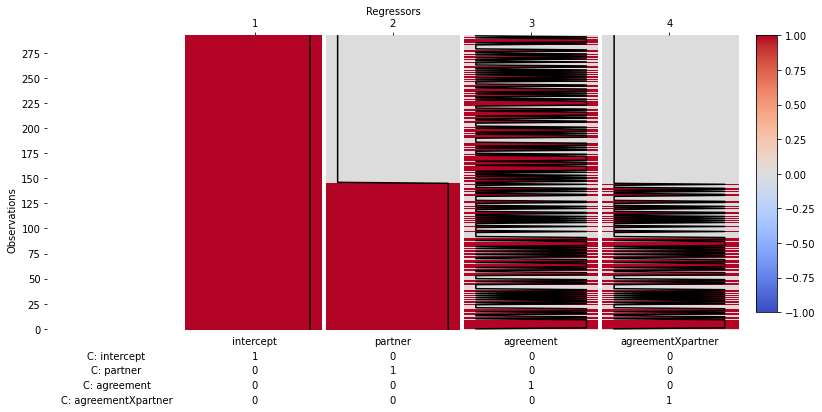

In [93]:
glmdes.plot_summary()
print()  



----------------------- Contrast intercept -----------------------




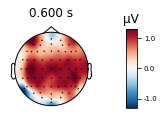

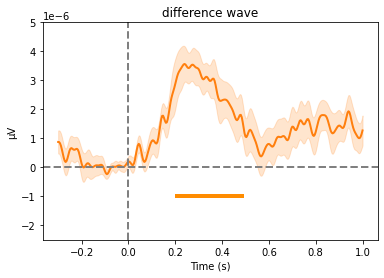



----------------------- Contrast agreementXpartner -----------------------




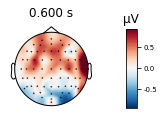

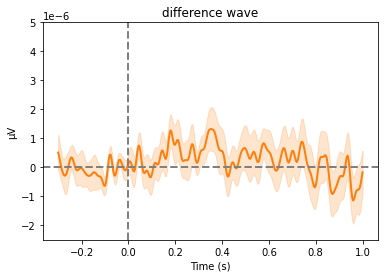



----------------------- Contrast partner -----------------------




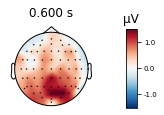

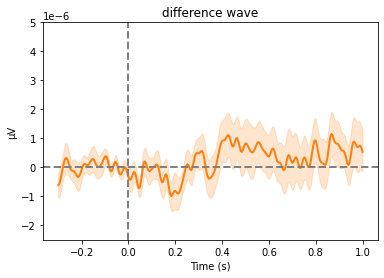



----------------------- Contrast agreement -----------------------




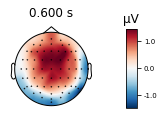

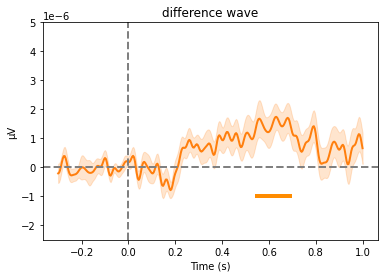

In [97]:
# Define the list of contrasts and region of interest
cs = ['intercept', 'agreementXpartner', 'partner', 'agreement']
#roi = ["Pz", "CPz", "POz", "P1", "P2"]
roi = ["FCz"]

sub_betacoefs = dict()

# Loop through each contrast
for c in cs:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Contrast %s -----------------------\n" % c)
    print('\033[0m')

    # Initialize an empty list for storing betas of each subject
    sub_betas = []

    # Loop through each subject and read their beta values
    for subject in participant_numbers:   
        sub_beta = mne.read_evokeds(fname='/Users/majaf/Desktop/Google Drive/PhD/Study 5 Confidence Matching with EEG (A)/Data Analysis/BetasEpochs/%s_%i-ave.fif' % (c, subject))[0]
        sub_betas.append(sub_beta)

    # Compute the grand average of beta values
    gave = mne.grand_average(sub_betas)

    # Plot the grand average topomap for the current contrast
    fig = gave.plot_topomap(times=[0.6], average=0.2, contours=0, extrapolate='head')
    fig.savefig('Figures/contrast_topoplot_informational_FCz_%s.pdf' % c, bbox_inches='tight')

    # Store betas in a dictionary
    sub_betacoefs[c] = deepcopy(sub_betas)

    # Set the time window for clustering
    tmin, tmax = 0.2, 1

    # Initialize dictionaries for storing cluster test results
    t_cope, clu_cope, clupv_cope, h0_cope, masks_cope = dict(), dict(), dict(), dict(), dict()

    # Create nested dictionaries for the current contrast and each channel in the ROI
    for contrast in [c]:
        for dictobj in [t_cope, clu_cope, clupv_cope, h0_cope, masks_cope]:
            dictobj[contrast] = dict()
            for channel in roi:
                dictobj[contrast][channel] = []

    # Get the time values for the clustering
    clutimes = deepcopy(sub_betacoefs[c][0]).crop(tmin=tmin, tmax=tmax).times

    # Run the cluster test for the current contrast and each channel in the ROI
    for contrast in [c]:
        for channel in roi:
            t_cope[contrast][channel], clu_cope[contrast][channel], clupv_cope[contrast][channel], h0_cope[contrast][channel] = runclustertest_epochs(
                        data=sub_betacoefs,
                        contrast_name=contrast,
                        channels=[channel],
                        tmin=tmin, tmax=tmax,
                        gauss_smoothing=None,
                        out_type='indices', n_permutations=5000)
            masks_cope[contrast][channel] = np.asarray(clu_cope[contrast][channel])[clupv_cope[contrast][channel] < 0.05]

    # Plot the time course for the current contrast and each channel in the ROI
    for channel in roi:
        tmp = mne.grand_average(sub_betacoefs[c])
        tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])]
        nsubs = len(sub_betacoefs[c])
        ntimes = sub_betacoefs[c][0].times.size
        times = sub_betacoefs[c][0].times
        tmpempty = np.empty(shape=(nsubs, ntimes))
        
        # Calculate the mean and standard error of the mean for each time point
        for i in range(nsubs):
            tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[c][i]).pick_channels([channel]).get_data())
        tmpmean = np.nanmean(tmpempty, 0)
        tmpsem  = sp.stats.sem(tmpempty, 0)

        # Create a new figure for the time course plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(times, tmpmean, lw=2, color='C1')
        ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color='C1')
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')

        # Plot significant clusters on the time course plot
        for contrast in [c]:
            y_sig = -1e-6
            if contrast == "confidence":
                y_sig = -1e-6
            for imask in range(len(masks_cope[contrast][channel])):
                ax.hlines(y=y_sig,
                          xmin=np.min(clutimes[masks_cope[contrast][channel][imask][1]]),
                          xmax=np.max(clutimes[masks_cope[contrast][channel][imask][1]]),
                          lw=4, color='darkorange')

        # Set the title and save the figure
        # ax.set_title(f'Electrode {channel} - difference wave')
        ax.set_ylim([-2.5e-6, 5e-6])
        
        # Set the X-axis and Y-axis labels
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('µV')
        ax.set_title('difference wave')
        fig.savefig('Figures/contrast_timecourse_informational_FCz_%s.pdf' % c, bbox_inches='tight')

        # Display the figure and close it
        display(fig)
        plt.close()








----------------------- Model agreementXpartner -----------------------




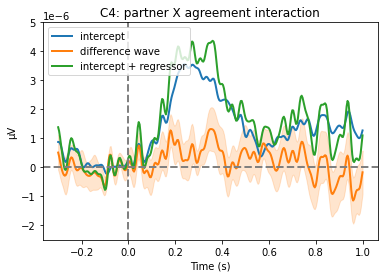



----------------------- Model partner -----------------------




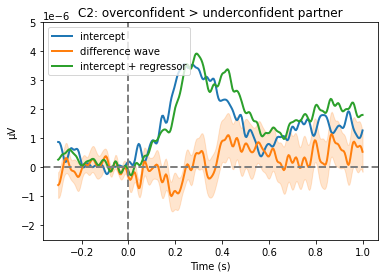



----------------------- Model agreement -----------------------




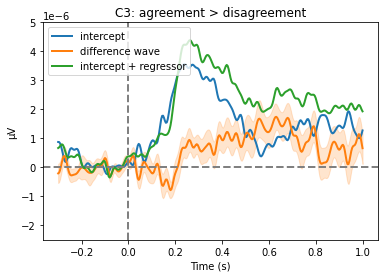

In [95]:
plot_titles = {
    "agreementXpartner": "C4: partner X agreement interaction",
    "partner": "C2: overconfident > underconfident partner",
    "agreement": "C3: agreement > disagreement"
}

# Loop through each contrast
for c in cs[1:]:
    # Print the current contrast as a header
    print('\033[1m' + "\n\n----------------------- Model %s -----------------------\n" % c)
    print('\033[0m')

    # Loop through each channel in the ROI
    for channel in roi:
        # Create a new figure for the time course plot
        fig, ax = plt.subplots()

        for idx, (contrast, label) in enumerate(zip([cs[0], c], ['intercept', f'difference wave'])):

            # Compute the grand average of beta values
            tmp = mne.grand_average(sub_betacoefs[contrast])
            tmpdata = [x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[contrast])]
            nsubs = len(sub_betacoefs[contrast])
            ntimes = sub_betacoefs[contrast][0].times.size
            times = sub_betacoefs[contrast][0].times
            tmpempty = np.empty(shape=(nsubs, ntimes))

            # Calculate the mean and standard error of the mean for each time point
            for i in range(nsubs):
                tmpempty[i, :] = np.squeeze(deepcopy(sub_betacoefs[contrast][i]).pick_channels([channel]).get_data())
            tmpmean = np.nanmean(tmpempty, 0)
            tmpsem  = sp.stats.sem(tmpempty, 0)

            # Plot the time course
            color = f'C{idx}'
            if c != 'confidence' or idx != 0:  # Remove the intercept line from the first (confidence) plot
                ax.plot(times, tmpmean, lw=2, color=color, label=label)
                if idx == 1:  # Only plot standard error for the orange line (Difference Wave)
                    ax.fill_between(times, y1=np.subtract(tmpmean, tmpsem), y2=np.add(tmpmean, tmpsem), alpha=0.2, color=color)

        intercept_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[cs[0]])])
        contrast_data = np.array([x.pick_channels([channel]).get_data() for x in deepcopy(sub_betacoefs[c])])

        if c == 'confidence':
            # Plot the effect of confidence at different levels
            for level, label, color in zip([0, +1], ['intercept','+1 SD'], ['C0', 'C2']):
                combined_data = intercept_data + (contrast_data * level)
                combined_mean = np.nanmean(combined_data, axis=0)
                combined_sem = sp.stats.sem(combined_data, axis=0)

                ax.plot(times, combined_mean.squeeze(), lw=2, color=color, label=f'confidence ({label})')
        else:
            combined_data = intercept_data + contrast_data
            combined_mean = np.nanmean(combined_data, axis=0)     
            combined_sem = sp.stats.sem(combined_data, axis=0)

            ax.plot(times, combined_mean.squeeze(), lw=2, color='C2', label=f'intercept + regressor')

        # Set up the figure
        ax.axhline(y=0, ls='dashed', lw=2, color='grey')
        ax.axvline(x=0, ls='dashed', lw=2, color='grey')
        ax.set_title(plot_titles[c])
        ax.legend(loc='upper left')
        ax.set_ylim([-2.5e-6, 5e-6])
        
        # Set the X-axis and Y-axis labels
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('µV')

        # Save and display the figure
        fig.savefig(f'Figures/model_timecourse_informational_FCz_{c}.pdf', bbox_inches='tight')
        display(fig)
        plt.close()

